# Исследование объявлений о продаже квартир

На основе архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет, нужно научиться определять рыночную стоимость объектов недвижимости. 
Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

   total_images  last_price  total_area first_day_exposition  rooms  \

0            20  13000000.0      108.00  2019-03-07T00:00:00      3   

1             7   3350000.0       40.40  2018-12-04T00:00:00      1   

2            10   5196000.0       56.00  2015-08-20T00:00:00      2   

3             0  64900000.0      159.00  2015-07-24T00:00:00      3   

4             2  10000000.0      100.00  2018-06-19T00:00:00      2   

5            10   2890000.0       30.40  2018-09-10T00:00:00      1   

6             6   3700000.0       37.30  2017-11-02T00:00:00      1   

7             5   7915000.0       71.60  2019-04-18T00:00:00      2   

8            20   2900000.0       33.16  2018-05-23T00:00:00      1   

9            18   5400000.0       61.00  2017-02-26T00:00:00      3   



   ceiling_height  floors_total  living_area  floor is_apartment  ...  \

0            2.70          16.0        51.00      8          NaN  ...   

1             NaN          11.0        18.60      1       

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

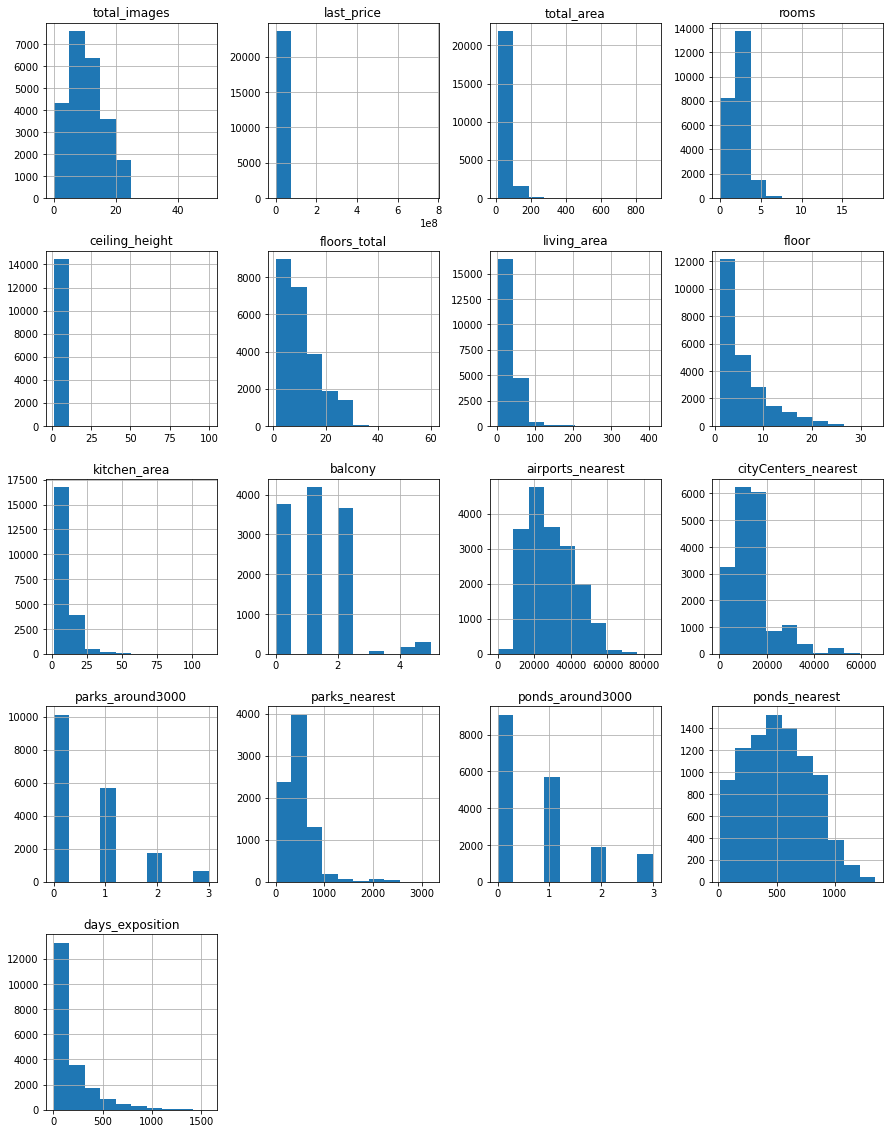

In [2]:

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #открыли файл в пандас, разделитель /t
print(data.head(10)) #вывели первые 10 строк датасета
data.info() #получили информацию о датасете
data.hist(figsize = (15, 20)) #построили гистограммы для всех типов значений датасета


Из выведенных данных мы видим, что в датасете в отдельных столбцах имеются пропуски (значения NaN), а также нетипичные для колонок данные - например значения высот потолков в 25 метров. Также можно отметить, что некоторые данные, например расстояния, не округлены и находятся в метрах - гораздо удобнее их в дальнейшем округлить до целых чисел и перевести необходимые нам в км. Также видно, что в названиях населенных пунктов встречаются дубликаты (один и тот же населенный пункт с разными типами - поселок, поселок городского типа итд.). 

Займемся предобработкой данных, чтобы сделать наши данные для анализа более однородными и понятными.

### Предобработка данных

#### Работа с пропусками

In [3]:
print(data.isna().sum()) #проверяем столбцы датасета на предмет пропусков


total_images                0

last_price                  0

total_area                  0

first_day_exposition        0

rooms                       0

ceiling_height           9195

floors_total               86

living_area              1903

floor                       0

is_apartment            20924

studio                      0

open_plan                   0

kitchen_area             2278

balcony                 11519

locality_name              49

airports_nearest         5542

cityCenters_nearest      5519

parks_around3000         5518

parks_nearest           15620

ponds_around3000         5518

ponds_nearest           14589

days_exposition          3181

dtype: int64


По полученным данным видим, что в датасете имеются пропущенные значения. Разберемся детально с каждыми из них:

Пропущенные значения в графе "высота потолков" можно заменить на медианное

In [4]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) 
#заполнили высоту потолков медианным значением

Пропущенных значений количества этажей в данных не так много - исключим эти пропуски, чтобы нивелировать их влияние на дальнейшее исследование

In [5]:
data = data.dropna(axis =0, subset=['floors_total'])
data = data.reset_index(drop=True)

In [6]:
print(len(data[data['floors_total'].isna()]))

0


Строки с пропущенными значениями из датасета успешно удалены.

Следующая графа, "размер жилой площади", заполним медианой, с учетом количества комнат. Так будет точнее для дальнейшего анализа.

In [7]:
for q in data['rooms'].unique():
    data.loc[(data['rooms'] == q)&(data['living_area'].isna()), 'living_area']=\
    data.loc[(data['rooms']==q), 'living_area'].median()
        #заполняем пропуски жилплощади медианным значением в зависимоти от количества комнат

Размер площади кухни не так сильно необходим для дальнейшего анализа. Оставим ти пропуски

Количество пропусков в графе "балконы" заменим на 0, так как можно предположить, что если значение пропущено - балкона просто нет

In [8]:
data['balcony']=data['balcony'].fillna(0)

Параметр "является апартаментами" указывает на то является квартира апартаментами или нет. Пропуски в данной графе заменим на False - можно предположить, что пропущенное значение говорит о том, что квартира апартаментами не является

In [9]:
data['is_apartment']=data['is_apartment'].fillna(False)

Пропуски в графе "название населенного пункта также удаляем - они не критичны для дальнейшего анализа

In [10]:
data['locality_name'].fillna('', inplace=True)
data['locality_name'].dropna(inplace=True)

Расстояния до ближайшийх объектов также не играют большую роль в дальнейшем анализе. Оставим эти пропуски

Графа "время размещения обявления" также содержит пропуски. Их не так много, чтобы они были значительны для дальнейшего анализа. Также оставим их

In [11]:
print(data.isna().sum()) #проверим как заменились пропуски

total_images                0

last_price                  0

total_area                  0

first_day_exposition        0

rooms                       0

ceiling_height              0

floors_total                0

living_area                 0

floor                       0

is_apartment                0

studio                      0

open_plan                   0

kitchen_area             2231

balcony                     0

locality_name               0

airports_nearest         5532

cityCenters_nearest      5509

parks_around3000         5508

parks_nearest           15568

ponds_around3000         5508

ponds_nearest           14552

days_exposition          3172

dtype: int64


Как видим - пропуски в интересующих нас категориях пропали. В целом, пропуски могли появиться из-за ошибок при заполнении в данных или проблем с автоматическим заполнением - как видим из вызванного метода, очень много пропусков было в графах с расстоянием до ближайшего чего-то (пруда, центра, аэропорта итд.), а эти данные, исходя из условия, заполняются автоматически.

#### Изменение типов данных

Вызовим метод info() чтобы посмотреть какие типы данных есть в колонках датасета

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 23613 entries, 0 to 23612

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   total_images          23613 non-null  int64  

 1   last_price            23613 non-null  float64

 2   total_area            23613 non-null  float64

 3   first_day_exposition  23613 non-null  object 

 4   rooms                 23613 non-null  int64  

 5   ceiling_height        23613 non-null  float64

 6   floors_total          23613 non-null  float64

 7   living_area           23613 non-null  float64

 8   floor                 23613 non-null  int64  

 9   is_apartment          23613 non-null  bool   

 10  studio                23613 non-null  bool   

 11  open_plan             23613 non-null  bool   

 12  kitchen_area          21382 non-null  float64

 13  balcony               23613 non-null  float64

 14  locality_name         23613 non-null  object 

 15 

Заменим тип данных на int в следущих колонках:

In [13]:
data['floors_total']=data['floors_total'].astype('int', errors='ignore')
data['balcony']=data['balcony'].astype('int', errors='ignore')
data['parks_around3000']=data['parks_around3000'].astype('int', errors='ignore')
data['ponds_around3000']=data['ponds_around3000'].astype('int', errors='ignore')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>

RangeIndex: 23613 entries, 0 to 23612

Data columns (total 22 columns):

 #   Column                Non-Null Count  Dtype  

---  ------                --------------  -----  

 0   total_images          23613 non-null  int64  

 1   last_price            23613 non-null  float64

 2   total_area            23613 non-null  float64

 3   first_day_exposition  23613 non-null  object 

 4   rooms                 23613 non-null  int64  

 5   ceiling_height        23613 non-null  float64

 6   floors_total          23613 non-null  int64  

 7   living_area           23613 non-null  float64

 8   floor                 23613 non-null  int64  

 9   is_apartment          23613 non-null  bool   

 10  studio                23613 non-null  bool   

 11  open_plan             23613 non-null  bool   

 12  kitchen_area          21382 non-null  float64

 13  balcony               23613 non-null  int64  

 14  locality_name         23613 non-null  object 

 15 

#### Работа с дубликатами

Замемся дубликатами в столбце "название населенного пункта"

In [15]:
data.duplicated() #найдем полные дубликаты строк

0        False
1        False
2        False
3        False
4        False
         ...  
23608    False
23609    False
23610    False
23611    False
23612    False
Length: 23613, dtype: bool

In [16]:
data.drop_duplicates(keep='first') #сбросим их, оставляя только первые

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16,51.0,8,False,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.65,11,18.6,1,False,...,11.00,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.65,5,34.3,4,False,...,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,2.65,14,45.0,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14,32.0,13,False,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23608,9,9700000.0,133.81,2017-03-21T00:00:00,3,3.70,5,73.3,3,False,...,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,NaN
23609,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.65,5,38.0,4,False,...,8.50,0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23610,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.65,3,29.7,1,False,...,NaN,0,село Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23611,13,11475000.0,76.75,2017-03-28T00:00:00,2,3.00,17,30.5,12,False,...,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0


In [17]:
data['locality_name'].value_counts()

Санкт-Петербург                       15651
посёлок Мурино                          520
посёлок Шушары                          439
Всеволожск                              398
Пушкин                                  369
                                      ...  
поселок Коробицыно                        1
посёлок Дзержинского                      1
коттеджный поселок Кивеннапа Север        1
посёлок Плоское                           1
деревня Хязельки                          1
Name: locality_name, Length: 365, dtype: int64

Как видим из результата выше, а также первых строк всей таблицы - много дубликатов будет на разнице букв е/ё, названий "поселок городского типа", "поселок", "деревня" итд. заменим эти значения и избавимся от дубликатов.

In [18]:
data['locality_name']=(data['locality_name'].str.replace('ё', 'е').replace('городской', '').replace('городского типа', '').replace('коттеджныйпоселок', 'поселок').replace(' поселок', 'поселок'))

Проверим как изменились названия в датасете

In [19]:
data['locality_name'].value_counts()

Санкт-Петербург                       15651
поселок Мурино                          552
поселок Шушары                          439
Всеволожск                              398
Пушкин                                  369
                                      ...  
коттеджный поселок Кивеннапа Север        1
поселок Коммунары                         1
поселок Дзержинского                      1
поселок Цвылево                           1
поселок Ромашки                           1
Name: locality_name, Length: 331, dtype: int64

Колчество строк изменилось - с 365 до 311, итого мы избавились от 54 дублирующих значений.

Данные приведены к общему виду. Продолжим предобработку

#### Обработка аномальных значений

Начнем с аномальных значений, которые попробуем найти с помощью диаграммы размаха

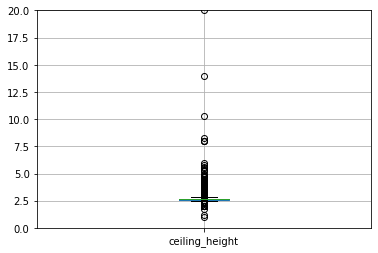

count    23613.000000
mean         2.724581
std          0.990085
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

In [20]:
 data.boxplot(column='ceiling_height')
plt.ylim(0, 20)
plt.show()
data['ceiling_height'].describe()

Видим, что выбросов много, начиная от 20м. Но высота потолка не может же быть такой. Скорее всего проблема в том, что между цифрами не стоит точка. Исправим это. Для этого поделим аномальные значения высота на 10, чтобы привести их к более реальным.

In [21]:
data['ceiling_height'] = np.round(data['ceiling_height'].where(data['ceiling_height']<20, data['ceiling_height']/10), 2)



Таже аномально низкие значения для высоты потолков также отбросим. Этими значениями будут выступать высоты меньше 2,6 метров. Избавимся от аномальных значений высот и оставим те значения, которые входят в промежуток 2,6 м - 5 м. 

In [22]:
data = data[(data["ceiling_height"] >= 2.6) & (data["ceiling_height"] <= 5)] 

In [23]:
# код ревьюера
data.shape[0] / 23699

0.992573526309127

Проверим, что все значения расположены в указанных выше пределах.

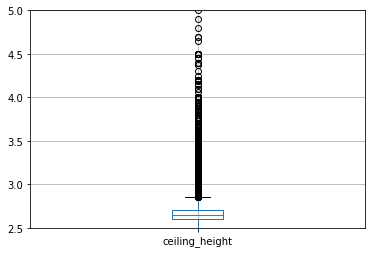

In [24]:
data.boxplot(column='ceiling_height')
plt.ylim(2.5, 5)
plt.show()

Как видим - избавиться от выбросов получилось. Высоты потолков приведены к реальным размерам.

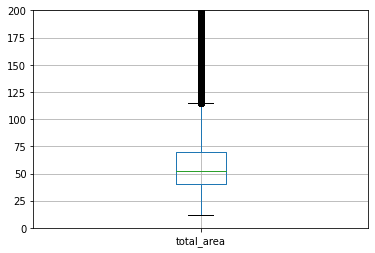

In [25]:
data.boxplot(column='total_area')
plt.ylim(0, 200)
plt.show()

Выбивающиеся значения по общей площади можно обосновать тем, что объекты с площадь болше 125 кв м существуют.

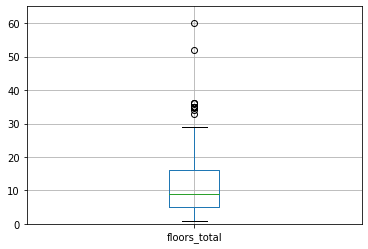

In [26]:
data.boxplot(column='floors_total')
plt.ylim(0, 65)
plt.show()

Многоэтажные новостройки с количеством этажей 30+ - это также не является аномалией. Но при этом максимальная высота домов (исходя из данных, которые удалось найти - это 36 этажей. Следовательно, удалим аномальные значения выше 36 этажей

In [27]:
data = data[data["floors_total"] <=36]

Проверим удаление аномальных значений 36+ этажей

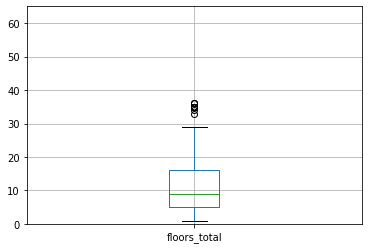

In [28]:
data.boxplot(column='floors_total')
plt.ylim(0, 65)
plt.show()

Удаление прошло успешно

In [29]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23521.000000,2.352100e+04,23521.000000,23521.000000,23521.000000,23521.000000,23521.000000,23521.000000,21302.000000,23521.000000,18021.000000,18044.000000,18045.000000,8006.000000,18045.000000,9028.000000,20362.000000
mean,9.878619,6.532571e+06,60.340626,2.071128,2.697245,10.680966,34.327013,5.881383,10.568924,0.592109,28793.228289,14183.772999,0.610086,490.638771,0.770019,518.341050,180.958648
std,5.679464,1.083874e+07,35.551900,1.078508,0.215358,6.586719,21.683562,4.877649,5.897508,0.959217,12626.351044,8611.062318,0.801329,341.925171,0.939171,277.972893,219.859831
min,0.000000,1.219000e+04,12.000000,0.000000,2.500000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.429000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.000000,0.000000,18575.000000,9234.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.300000,4.000000,9.100000,0.000000,26737.000000,13094.000000,0.000000,454.500000,1.000000,503.000000,95.000000
75%,14.000000,6.800000e+06,70.000000,3.000000,2.700000,16.000000,42.700000,8.000000,12.000000,1.000000,37268.000000,16287.000000,1.000000,612.000000,1.000000,730.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,5.000000,36.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


Так, мы проверили выборочно аномалии в тех столбцах, в которых они могут встречаться и быть критичны для дальнейшего анализа.

### Посчитайте и добавьте в таблицу новые столбцы

Необходимо добавить в данные следущие параметры:

1 цена одного квадратного метра;

2 день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);

3 месяц публикации объявления;

4 год публикации объявления;

5 тип этажа квартиры (значения — «‎первый», «последний», «другой»);

6 расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).

Начнем с цены кв метра

In [30]:
data['m_price']=data['last_price']/data['total_area']#цена на м кв рассчитывается как отношение последней цены к общей площади квартиры
data['m_price'].head(10)

0    120370.370370
1     82920.792079
2     92785.714286
3    408176.100629
4    100000.000000
5     95065.789474
6     99195.710456
7    110544.692737
8     87454.764777
9     88524.590164
Name: m_price, dtype: float64

Займемся днями публикации объявлений

In [31]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['first_day_exposition'].head(10)

0   2019-03-07
1   2018-12-04
2   2015-08-20
3   2015-07-24
4   2018-06-19
5   2018-09-10
6   2017-11-02
7   2019-04-18
8   2018-05-23
9   2017-02-26
Name: first_day_exposition, dtype: datetime64[ns]

In [32]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['weekday'] = data['first_day_exposition'].dt.weekday
data['weekday'].head(10)
#привели форматы даты/времени к единому образцу, затем с помощью метода weekday создали новый столбец в датасете
#куда поместили информацию о номере дня недели
    

0    3
1    1
2    3
3    4
4    1
5    0
6    3
7    3
8    2
9    6
Name: weekday, dtype: int64

Перейдем к месяцу публикации. Будем использовать метод dt.month

In [33]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['month'] = data['first_day_exposition'].dt.month
data['month'].head(10)

0     3
1    12
2     8
3     7
4     6
5     9
6    11
7     4
8     5
9     2
Name: month, dtype: int64

Год из строк достанем методом dt.year

In [34]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%d %H:%M')
data['year'] = data['first_day_exposition'].dt.year
data['year'].head(10)

0    2019
1    2018
2    2015
3    2015
4    2018
5    2018
6    2017
7    2019
8    2018
9    2017
Name: year, dtype: int64

После сверки 10 первых строк исходных и 10 строк после применения каждого метода видим, что все работает исправно. Переходим к категоризации этажей.

Для определения категории (этажа) создадим функцию floor_category и передадим ей следующие условия

In [35]:
def floor_category (row):
    if row['floor']==row['floors_total']:
        return 'последний'
    elif row['floor']== 1:
        return 'первый'
    else:
        return 'другой'
data['floor_category']=data.apply(floor_category, axis=1)

Вызовим первые 5 строк датасета, чтобы проверить добавленные столбцы

In [36]:
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m_price,weekday,month,year,floor_category
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,False,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,False,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,45.0,9,False,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,False,...,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой


Добавим столбец с расстоянием до центра города в КМ (переведем М в КМ и округлим до целых значений)

In [37]:
data['km_to_centre'] = data['cityCenters_nearest']/1000 #поделим расстояние на 1000м
data['km_to_centre'] = data['km_to_centre'].round(0) #округляем до целых чисел

Выведем первые 10 строк датасета и проверим все добавленные столбцы

In [38]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,m_price,weekday,month,year,floor_category,km_to_centre
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11,18.60,1,False,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5,34.30,4,False,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14,45.00,9,False,...,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12,14.40,5,False,...,NaN,NaN,NaN,55.0,95065.789474,0,9,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26,10.60,6,False,...,NaN,0.0,NaN,155.0,99195.710456,3,11,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24,30.50,22,False,...,NaN,0.0,NaN,NaN,110544.692737,3,4,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27,15.43,26,False,...,NaN,NaN,NaN,189.0,87454.764777,2,5,2018,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,NaN,0.0,NaN,289.0,88524.590164,6,2,2017,другой,15.0


### Проведите исследовательский анализ данных

#### Изучим необходимые параметры объектов, а именно: 
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.

Отдельно построим гистограммы для каждого и опишем наблюдения.

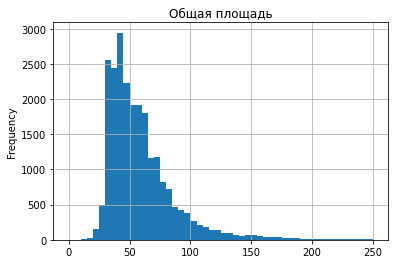

In [39]:
data['total_area'].plot(kind = 'hist', bins=50, range=(0, 250), title = 'Общая площадь', grid =True)
plt.show()

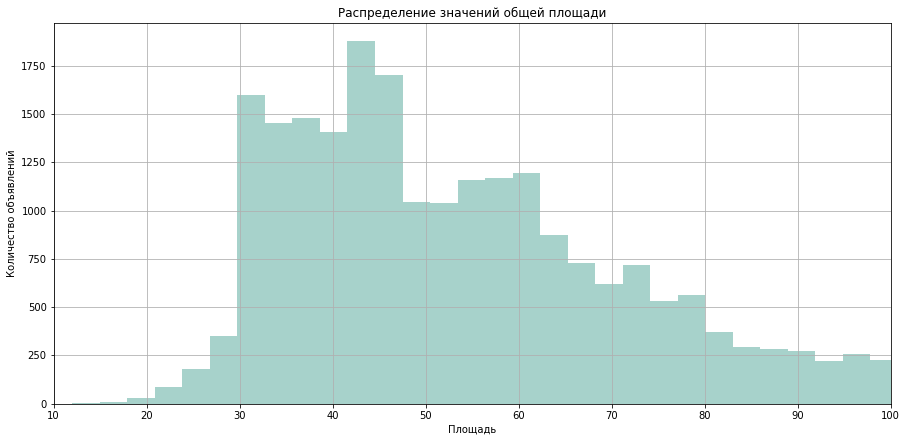

In [40]:
# код ревьюера


data['total_area'].hist(bins = 300, figsize = (15, 7), color='#A7D2CB')
plt.xlim(10, 100)

plt.title('Распределение значений общей площади')
plt.xlabel('Площадь') 
plt.ylabel('Количество объявлений')
plt.show()

Как видно из полученного графика - наибольшее количество квартир приходится на метраж 20-60 кв м. При этом на графике виден большой хвост - в сторону метража более 100 кв м. Нельзя сказать, что эти значения аномальны - такие площади квартир действительно существуют, и их на самом деле не так много.

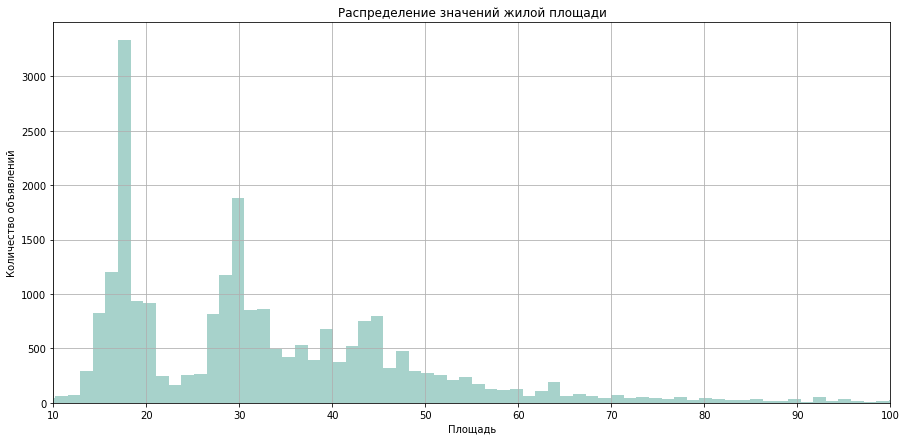

In [41]:
data['living_area'].hist(bins = 300, figsize = (15, 7), color='#A7D2CB')
plt.xlim(10, 100)

plt.title('Распределение значений жилой площади')
plt.xlabel('Площадь') 
plt.ylabel('Количество объявлений')
plt.show()

Жилая площадь также колеблется в "нормальном" диапазоне 15-50 м кв. Данные значения также абсолютно нормальны. Здесь, хвост сопровождается также высокими значениями в 150-200 кв м.

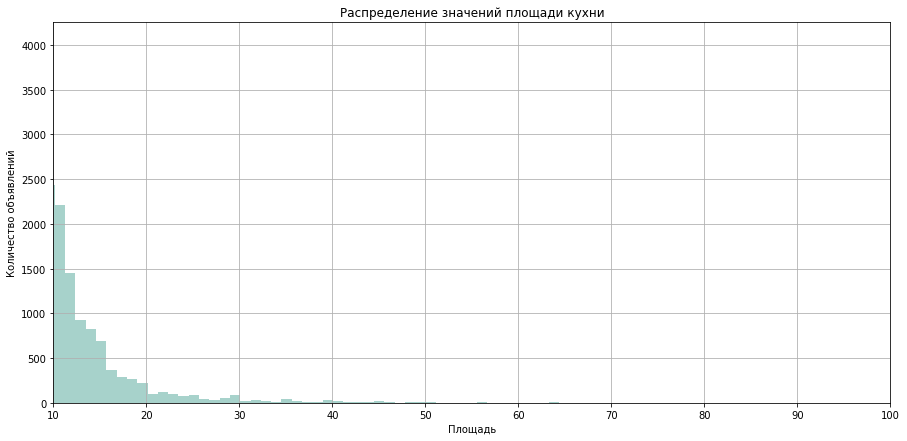

count    21302.000000
mean        10.568924
std          5.897508
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

In [42]:
data['kitchen_area'].hist(bins = 100, figsize = (15, 7), color='#A7D2CB')
plt.xlim(10, 100)

plt.title('Распределение значений площади кухни')
plt.xlabel('Площадь') 
plt.ylabel('Количество объявлений')
plt.show()
data['kitchen_area'].describe()

Средняя площадь кухонь составляет 10,5 кв м. Тут также не наблюдается аномальных выбросов.

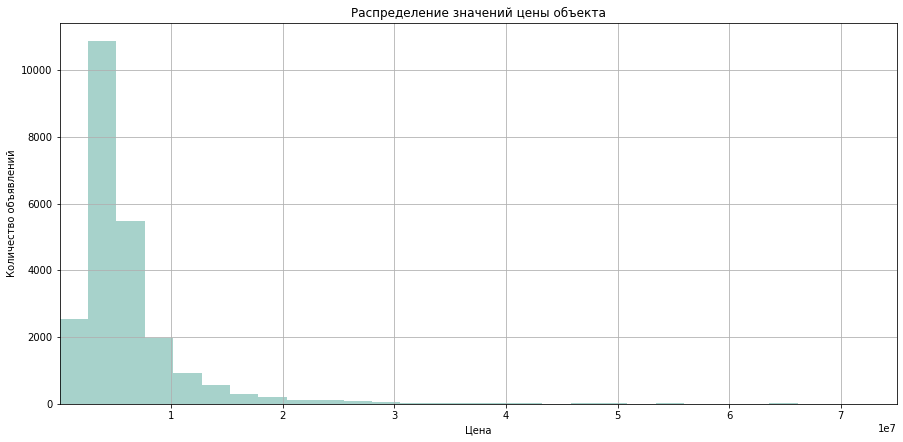

In [43]:
data['last_price'].hist(bins = 300, figsize = (15, 7), color='#A7D2CB')
plt.xlim(10, 75000000)

plt.title('Распределение значений цены объекта')
plt.xlabel('Цена') 
plt.ylabel('Количество объявлений')
plt.show()
plt.show()

Данный график показывает разброс цены до 75 млн рублей за объект. Мы видим, что пик предложений находится в диапазоне 4-9 млн рублей за квартиру. Хвост, где ценник уходит за 30 млн подтверждает предыдущие выводы о квартирах площадью за 150 кв м.

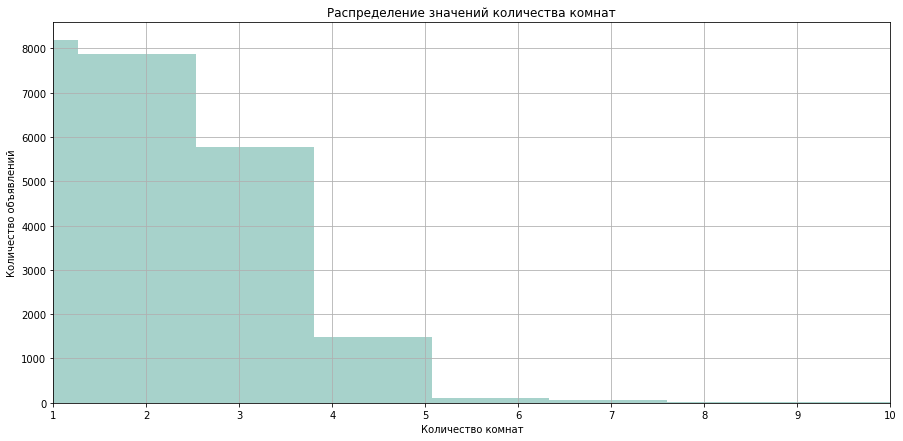

In [44]:
data['rooms'].hist(bins = 15, figsize = (15, 7), color='#A7D2CB')
plt.xlim(1, 10)

plt.title('Распределение значений количества комнат')
plt.xlabel('Количество комнат') 
plt.ylabel('Количество объявлений')
plt.show()

Наибольшее предложение исходя из графика является на однокомнатные квартиры. Следом идут двушки, а затем трешки.

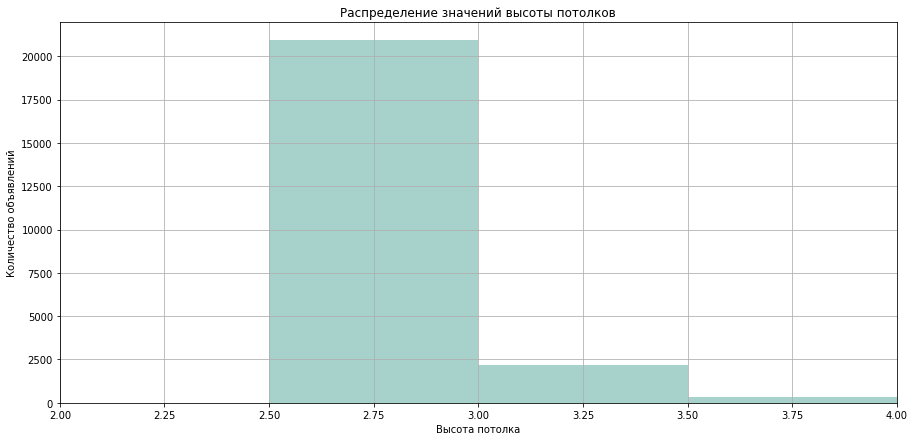

In [45]:
data['ceiling_height'].hist(bins = 5, figsize = (15, 7), color='#A7D2CB')
plt.xlim(2, 4)

plt.title('Распределение значений высоты потолков')
plt.xlabel('Высота потолка') 
plt.ylabel('Количество объявлений')
plt.show()

Высота потолков, после нашего изменения данных на более реальные, колеблется между 2,5-2,75 метров - это стандартная высота потолков во многих квартирах.

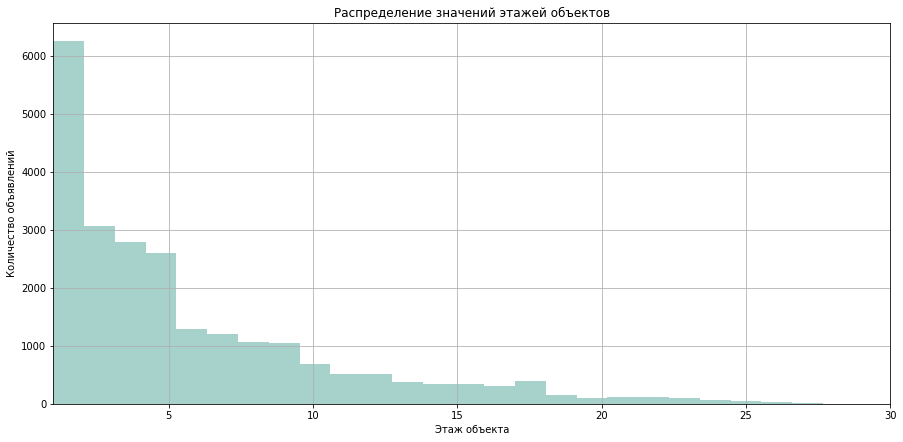

In [46]:
data['floor'].hist(bins = 30, figsize = (15, 7), color='#A7D2CB')
plt.xlim(1, 30)

plt.title('Распределение значений этажей объектов')
plt.xlabel('Этаж объекта') 
plt.ylabel('Количество объявлений')
plt.show()

Предложение квартир по этажам в основном в диапазоне 1-5 этаж

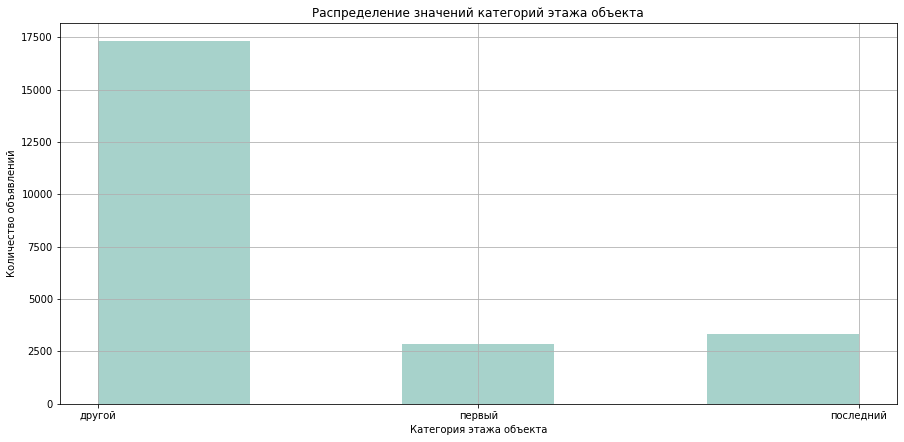

In [47]:
data['floor_category'].hist(bins = 5, figsize = (15, 7), color='#A7D2CB')

plt.title('Распределение значений категорий этажа объекта')
plt.xlabel('Категория этажа объекта') 
plt.ylabel('Количество объявлений')
plt.show()

При этом, предложения на 1 этаже самые малочисленные - отсюда, и на основании предыдущего графика, можно сделать вывод, что самые ходовые этажи со 2 по 4

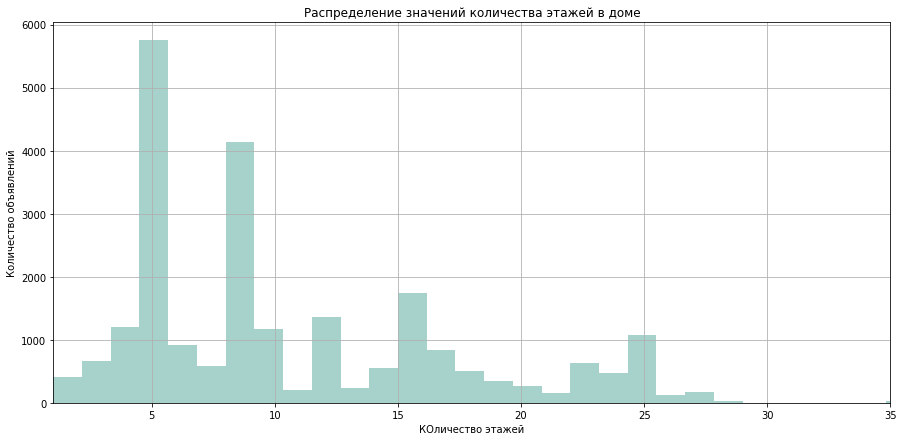

In [48]:
data['floors_total'].hist(bins = 30, figsize = (15, 7), color='#A7D2CB')
plt.xlim(1, 35)

plt.title('Распределение значений количества этажей в доме')
plt.xlabel('КОличество этажей') 
plt.ylabel('Количество объявлений')
plt.show()

Петербург не многоэтажный город сам по себе. Отсюда мы видим, что общее количество этажей в доме редко превышает 5. Вторые типы домов по популярности - девятиэтажки, и совсем редко встречаются многоэтажные дома (10+ этажей)

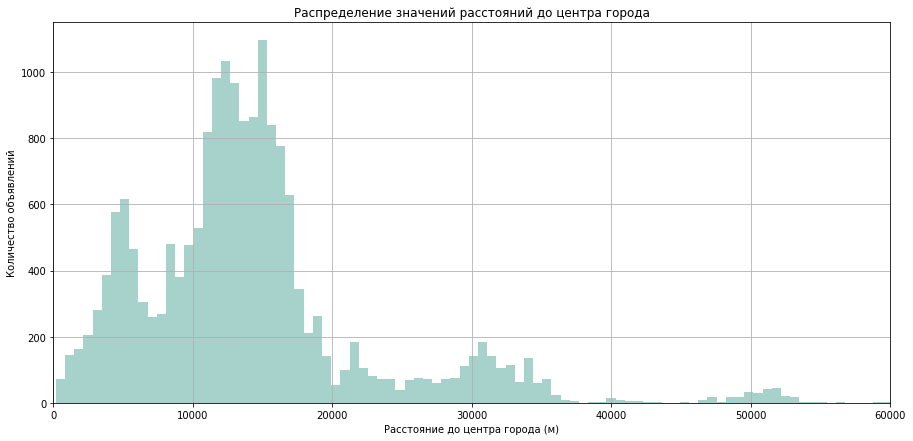

In [49]:
data['cityCenters_nearest'].hist(bins = 100, figsize = (15, 7), color='#A7D2CB')
plt.xlim(0, 60000)

plt.title('Распределение значений расстояний до центра города')
plt.xlabel('Расстояние до центра города (м)') 
plt.ylabel('Количество объявлений')
plt.show()

Переводя из км в м, мы получаем, что среднее расстояние до центра города является 10 с небольшим км. Также подъемы значений есть на 30 и 50 км от города - их можно объяснить тем, что в выборке участвуют квартиры, расположенные в пригородах Петербурга.

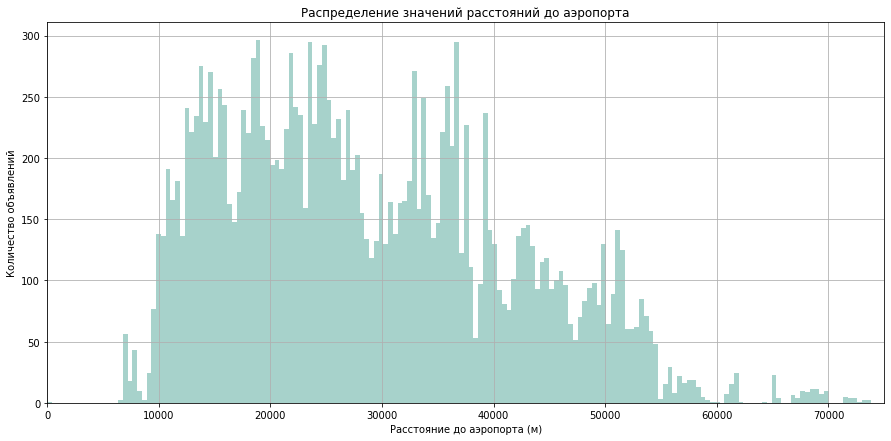

In [50]:
data['airports_nearest'].hist(bins = 200, figsize = (15, 7), color='#A7D2CB')
plt.xlim(0, 75000)

plt.title('Распределение значений расстояний до аэропорта')
plt.xlabel('Расстояние до аэропорта (м)') 
plt.ylabel('Количество объявлений')
plt.show()

Самое часто встречающееся расстояние до аэропорта колеблется от 15 до 25 км. Аэропорт расположен загородом.

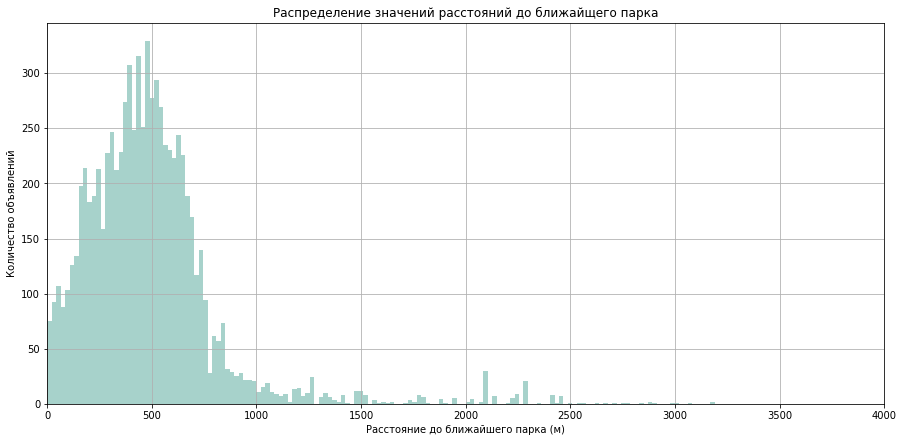

count    8006.000000

mean      490.638771

std       341.925171

min         1.000000

25%       288.000000

50%       454.500000

75%       612.000000

max      3190.000000

Name: parks_nearest, dtype: float64

23521


In [51]:
data['parks_nearest'].hist(bins = 150, figsize = (15, 7), color='#A7D2CB')
plt.xlim(0, 4000)

plt.title('Распределение значений расстояний до ближайщего парка')
plt.xlabel('Расстояние до ближайшего парка (м)') 
plt.ylabel('Количество объявлений')
plt.show()
print(data['parks_nearest'].describe())
print(len(data))

По паркам можно сказать, что в каждом населенном пункте они есть в шаговой доступности. Отсюда такие небольшие расстояния. Также, введено всего 8045 значений из 23613 - данных для анализа слишком мало.

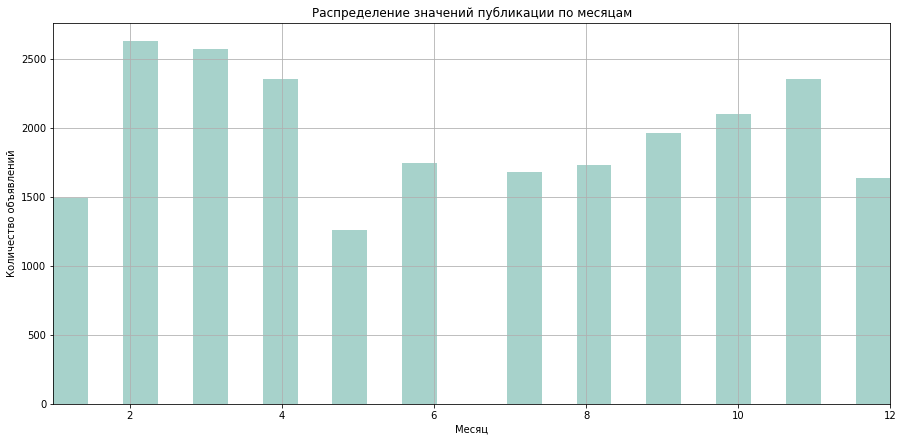

In [52]:
data['month'].hist(bins = 24, figsize = (15, 7), color='#A7D2CB')
plt.xlim(1, 12)

plt.title('Распределение значений публикации по месяцам')
plt.xlabel('Месяц') 
plt.ylabel('Количество объявлений')
plt.show()

Размещают объявления после Нового Года - февраль, март, апрель. И под конец года тренд на продажу растет. Это работает не только с рынком недвижимости, но и с другими рынками купли/продажи. Пик сезона начинается после новогодних праздников, затем спадает, а потом постепенно увеличивается к концу года

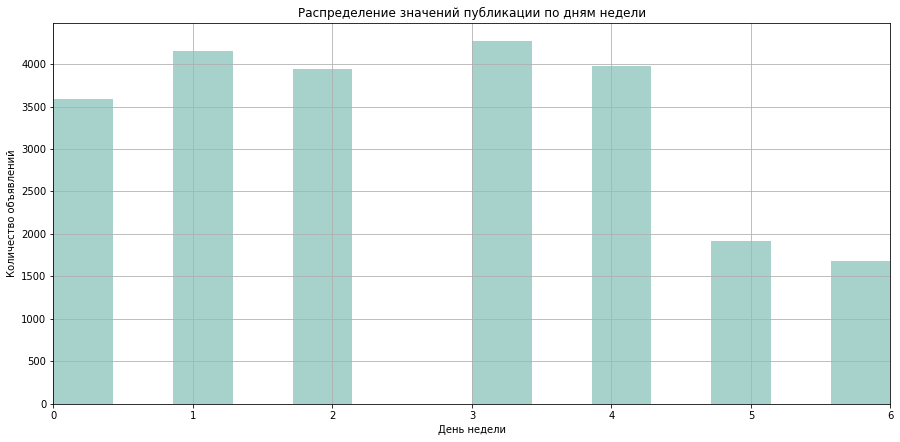

In [53]:
data['weekday'].hist(bins = 14, figsize = (15, 7), color='#A7D2CB')
plt.xlim(0, 6)

plt.title('Распределение значений публикации по дням недели')
plt.xlabel('День недели') 
plt.ylabel('Количество объявлений')
plt.show()

Объявления чаще размещают в будние дни, так как во время рабочей недели люди решают свои вопросы, в том числе с поиском и покупкой жилья. На выходных активность в размещении, а также поиске объявлений падает

#### Как быстро продавались квартиры

Исследуем насколько быстро продавались квартиры - для этого построим гистограмму, выделим среднее и медиану

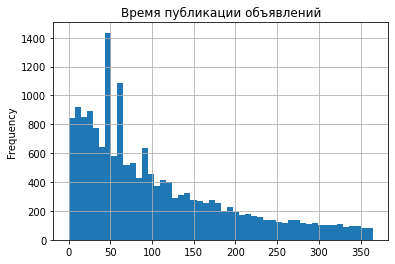

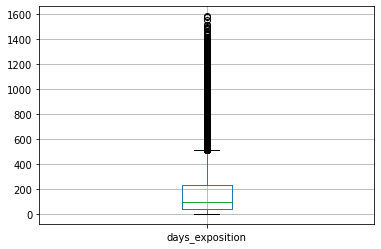

count    20362.000000
mean       180.958648
std        219.859831
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

In [54]:
data['days_exposition'].plot(kind = 'hist', bins=50, range=(0, 365), title = 'Время публикации объявлений', grid =True)
plt.show()
data.boxplot(column='days_exposition')
plt.show()
data['days_exposition'].describe()
#построим гистограмму и выведем ее описание

Из полученных данных видим, что медианное значение для продажи - 95 дней, а среднее 180 дней, что почти в 2 раза больше. Однозначно сказать почему квартиры продаются в разные сроки нельзя - это может зависеть и от качества объявления, от самого хозяина, от множества других факторов. Можно сказать, что самое быстро время продажи - 1 день, а максимальное - 1580 дней.

Количество дней "нормальной" продажи находится в границе Q1-Q3 и составляет от 1 до 232 дней. Все, что выходит за рамки усов графика будет аномально долгой продажей. Также, исходя из примененного метода describe, мы видим, что границы быстрой продажи квартиры будут находиться в пределах 1 - 44 дня, а долгой - свыше 215 дней.

#### Влияние на общую стоимость объекта

Изучим, как цена зависит и зависит ли вообще от:
общей площади;
жилой площади;
площади кухни;
количества комнат;
этажа, на котором расположена квартира (первый, последний, другой);
даты размещения (день недели, месяц, год).

Проверим зависимость от жилой площади. Для этого построим сводную таблицу методом pivot_table, а затем вызовим график

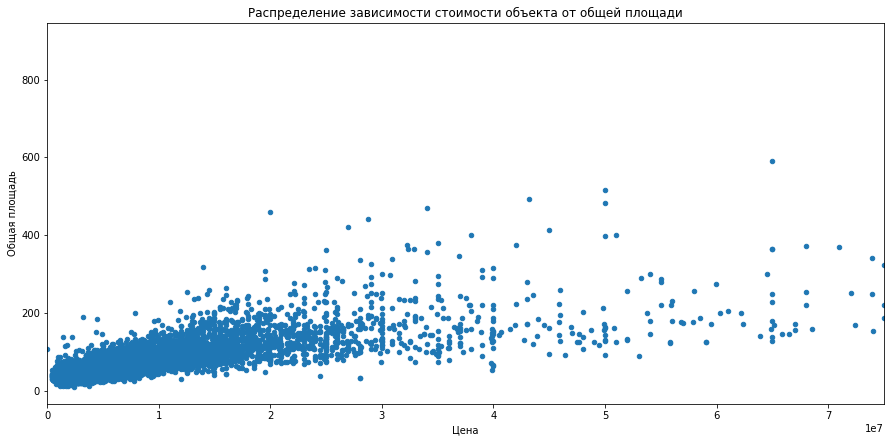

count    23521.000000
mean        60.340626
std         35.551900
min         12.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

In [55]:
data.plot(x='last_price', y='total_area', kind='scatter', figsize=(15, 7))
plt.xlim(0, 75000000)
plt.title('Распределение зависимости стоимости объекта от общей площади')
plt.xlabel('Цена') 
plt.ylabel('Общая площадь')
plt.show()
data['total_area'].describe()

Как мы видим из графика и сводной таблицы - цена объектов очень сильно зависит от общей площади, чем она выше, тем выше цена, что логично

Выясним зависимость от площади кухни. Также будем использовать сводную таблицу.

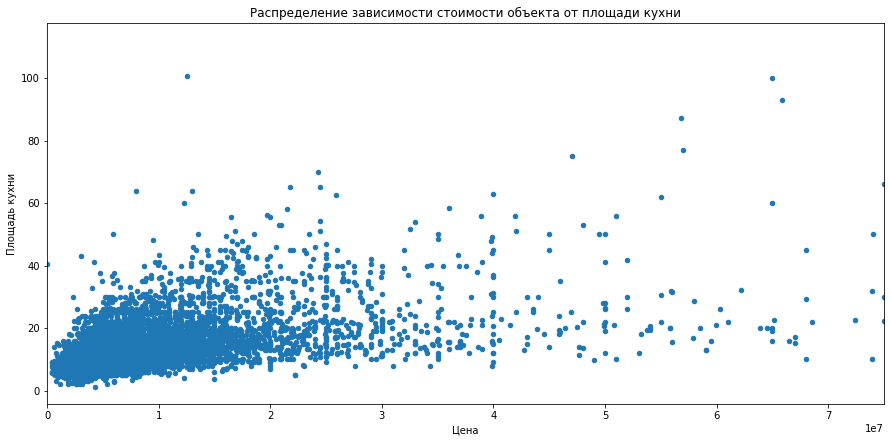

In [56]:
data.plot(x='last_price', y='kitchen_area', kind='scatter', figsize=(15, 7))
plt.xlim(0, 75000000)
plt.title('Распределение зависимости стоимости объекта от площади кухни')
plt.xlabel('Цена') 
plt.ylabel('Площадь кухни')
plt.show()

Здесь также видна возрастающая динамика зависимости цены объекта от размера кухни

Теперь выявим зависимость от количества комнат

         last_price

rooms              

0      3.319335e+06

1      3.836258e+06

2      5.597451e+06

3      8.176926e+06

4      1.333903e+07

5      2.328065e+07

6      3.154323e+07

7      5.147007e+07

8      5.022417e+07

9      3.415236e+07

10     2.616667e+07

11     2.525000e+07

12     4.200000e+08

14     2.682950e+07

15     6.500000e+07

16     2.850000e+07

19     3.225000e+07


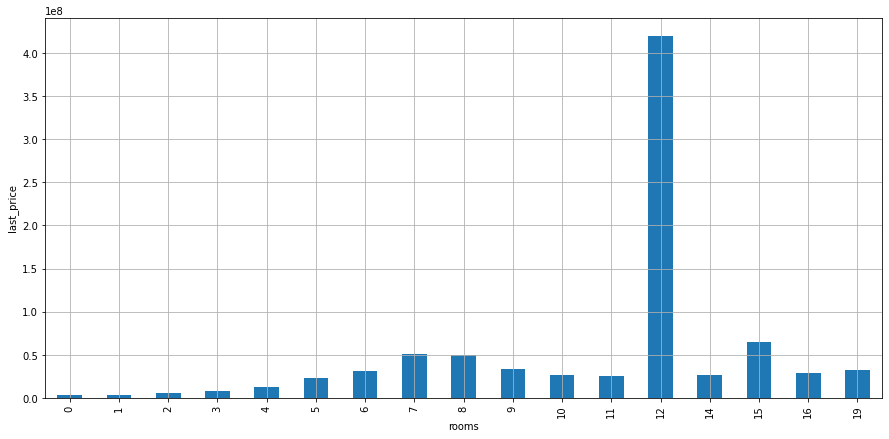

In [57]:
data_pivot = data.pivot_table(index= ['rooms'], values='last_price', aggfunc='mean')
print(data_pivot.sort_values(by='rooms'))
data_pivot['last_price'].plot(figsize=(15, 7), grid=True, kind='bar')
plt.ylabel('last_price')
plt.xlabel('rooms')
plt.show()

Зависимость от количества комнат будем смореть по диапазону до 40 млн за объект. Из графика видно, что оптимальное количество комнат, находится в диапазоне от 1 до 4х. Дальше цена то растет, то падает, что может свидетельствовать об индивидуальности каждого предложения по объектам. Пик значений приходится на 12 комнат - собственно эта позиция и дает такой большой разброс по цене

Перейдем к зависимости цены от категории этажа, на котором расположен объект

                  last_price

floor_category              

другой          6.677909e+06

первый          4.828572e+06

последний       7.247516e+06


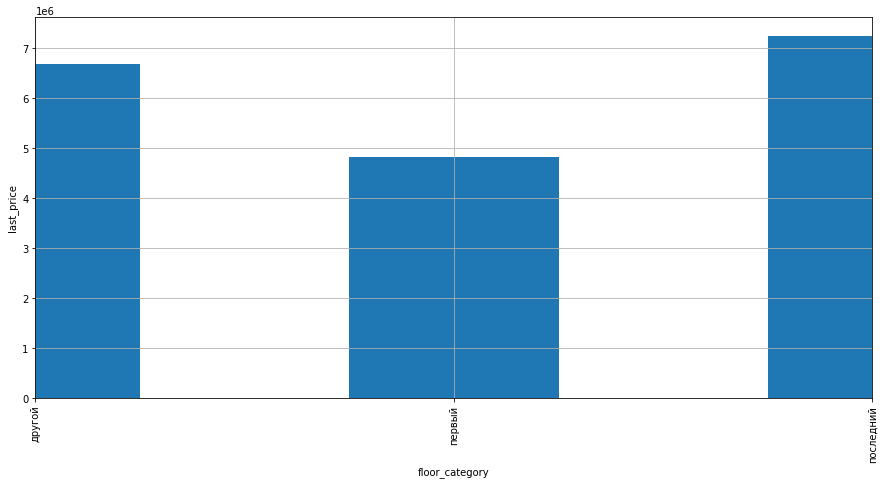

In [58]:
data_pivot = data.pivot_table(index= ['floor_category'], values='last_price', aggfunc='mean')
print(data_pivot.sort_values(by='floor_category'))
data_pivot['last_price'].plot(figsize=(15, 7), grid=True, kind='bar')
plt.ylabel('last_price')
plt.xlabel('floor_category')
plt.xlim(0, 2)
plt.show()




Исходя из полученной таблицы видим, что в среднем самые дорогие объекты расположены на последнем этаже, далее идут объекты, расположенные не на первом. Самые дешевые, относительно всех, те квартиры, которые находятся на 1 этаже

Рассмотри зависимость от даты размещения объявления (будем делать сводную талицу по параметрам день, месяц, год публикации)

In [59]:
data_pivot = data.pivot_table(index= ['last_price'], values=['weekday', 'month', 'year'] , aggfunc='mean')
print(data_pivot)

                 month  weekday     year

last_price                              

12190.0       3.000000     2.00  2019.00

430000.0      5.000000     0.50  2018.50

440000.0      7.000000     1.00  2018.00

450000.0      6.000000     2.25  2017.75

470000.0      3.666667     4.00  2018.00

...                ...      ...      ...

300000000.0  12.000000     0.00  2017.00

330000000.0   4.000000     2.00  2018.00

401300000.0   2.000000     5.00  2016.00

420000000.0  12.000000     2.00  2017.00

763000000.0   9.000000     5.00  2017.00



[2932 rows x 3 columns]


           last_price

weekday              

0        6.500891e+06

1        6.395652e+06

2        6.624856e+06

3        6.694091e+06

4        6.337630e+06

5        6.984297e+06

6        6.256910e+06


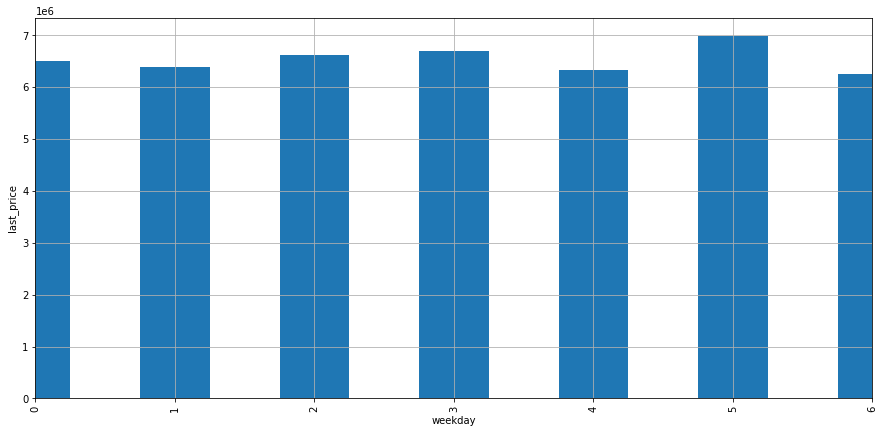

In [60]:
data_pivot = data.pivot_table(index= ['weekday'], values='last_price', aggfunc='mean')
print(data_pivot.sort_values(by='weekday'))
data_pivot['last_price'].plot(figsize=(15, 7), grid=True, kind='bar')
plt.ylabel('last_price')
plt.xlabel('weekday')
plt.xlim(0, 6)
plt.show()

Исходя из полученных данных мы видим, что значения цены относительно для недели публикации объявления в целом приблизительно одинаковы. Пик приходится на субботу, затем идет четверг и среда. Это не дает никакой зависисмости цены от дня недели публикации. Обратимся к зависимости от месяца

         last_price

month              

1      6.638814e+06

2      6.475324e+06

3      6.360999e+06

4      6.746405e+06

5      6.612152e+06

6      6.292931e+06

7      6.583688e+06

8      6.353380e+06

9      6.845759e+06

10     6.177309e+06

11     6.446989e+06

12     7.024256e+06


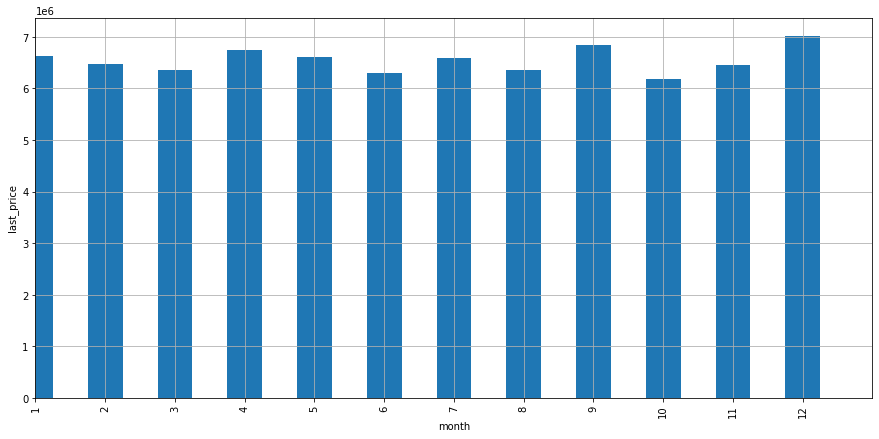

In [61]:
data_pivot = data.pivot_table(index= ['month'], values='last_price', aggfunc='mean')
print(data_pivot.sort_values(by='month'))
data_pivot['last_price'].plot(figsize=(15, 7), grid=True, kind='bar')
plt.ylabel('last_price')
plt.xlabel('month')
plt.xlim(0, 12)
plt.show()



Ситуация зависисмости от месяца публикации аналогична - явной зависимости не видно. Посмотрим зависимость от года.

        last_price

year              

2014  1.208714e+07

2015  8.489369e+06

2016  6.838693e+06

2017  6.573128e+06

2018  5.945745e+06

2019  6.783056e+06


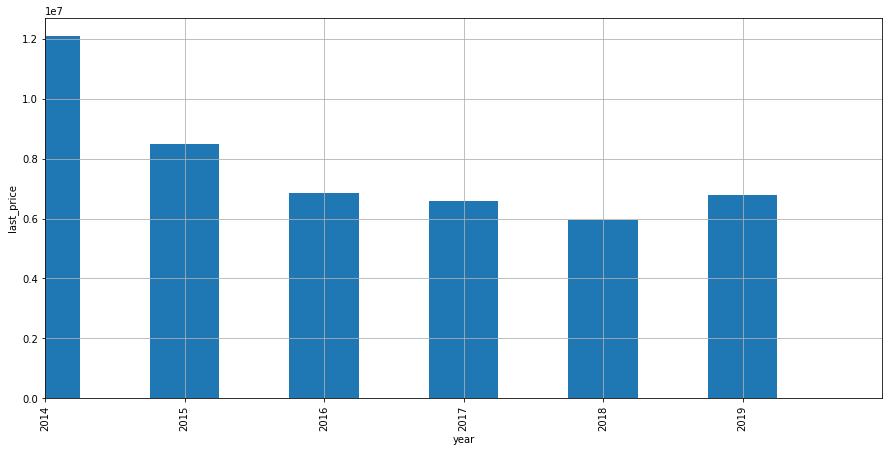

In [62]:
data_pivot = data.pivot_table(index= ['year'], values='last_price', aggfunc='mean')
print(data_pivot.sort_values(by='year'))
data_pivot['last_price'].plot(figsize=(15, 7), grid=True, kind='bar')
plt.ylabel('last_price')
plt.xlabel('year')
plt.xlim(0, 6)
plt.show()

В данной зависимости ситуация схожая, но наблюдается тренд на увеличение стоимости объектов с течением времени. Это можно объяснить тем, что цены на недвижимость с 2014 по 2019 год сильно выросли. 

Подытожив полученные данные, можно сказать, что зависимость цены объекта от времени публикации наблюдается только при увеличении года публикации - это связано с общим ростом цен на рынке недвижимости.

#### Рассчитаем цену 1 кв м в 10 населенных пунктах с самым большим количеством объявлений

Для начала построим сводную таблицу, чтобы выделить 10 наиболее популярных в объявлениях населенных пунктов

                     last_price

locality_name                  

Всеволожск         3.792819e+06

Выборг             3.260779e+06

Гатчина            3.488337e+06

Колпино            3.966585e+06

Пушкин             6.483946e+06

Санкт-Петербург    8.046774e+06

деревня Кудрово    4.234158e+06

поселок Мурино     3.654697e+06

поселок Парголово  4.492946e+06

поселок Шушары     4.109809e+06


Text(0.5, 0, 'locality_name')

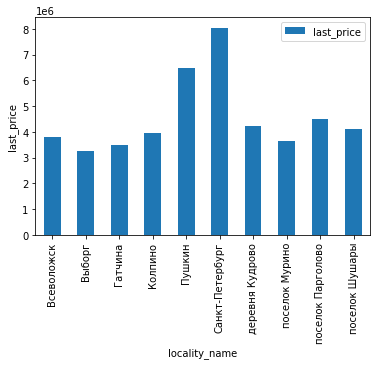

In [63]:
top_values_locality = data['locality_name'].value_counts().head(10).index
avg_price = (data.query('locality_name in @top_values_locality').pivot_table(index='locality_name', values='last_price', aggfunc='mean'))
print(avg_price)
avg_price.plot(kind='bar')
plt.ylabel('last_price')
plt.xlabel('locality_name')




Посмотрев график по сводной таблице мы видим десятку населенных пунктов с самым большим количеством объявлений. Найдем цену за 1 кв м из этой десятки.

                         m_price

locality_name                   

Выборг              58238.143141

Всеволожск          68719.320400

Гатчина             68746.146763

Колпино             75443.972838

поселок Шушары      78551.344545

поселок Мурино      85629.568678

поселок Парголово   90205.423758

деревня Кудрово     92473.547576

Пушкин             103147.825496

Санкт-Петербург    114796.493415


Text(0.5, 0, 'locality_name')

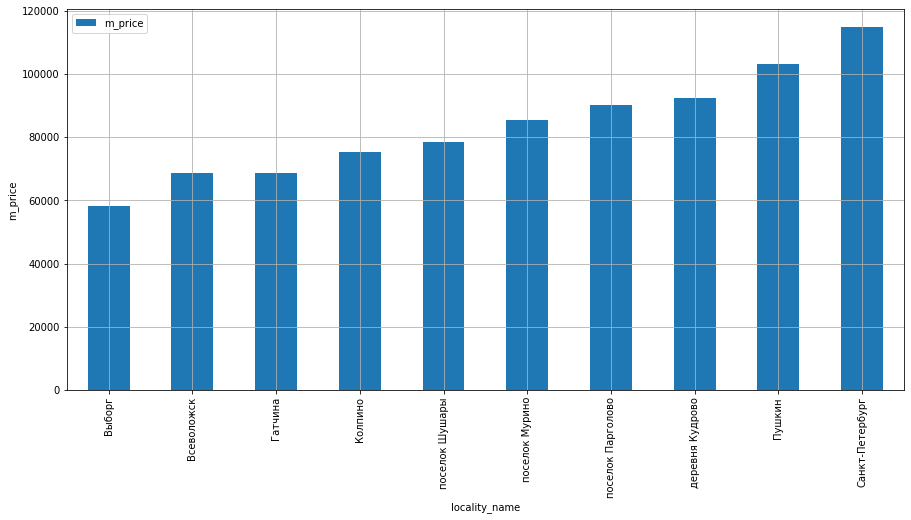

In [64]:
top_values_locality = data['locality_name'].value_counts().head(10).index
avg_price = (data.query('locality_name in @top_values_locality').pivot_table(index='locality_name', values='m_price', aggfunc='mean'))
print(avg_price.sort_values(by='m_price'))
avg_price.sort_values(by='m_price').plot(kind='bar', figsize=(15, 7), grid=True)
plt.ylabel('m_price')
plt.xlabel('locality_name')

Из созданного столбца цены за м кв получаем цену метра для каждого из 10 населенных пунктов. Узнать минимальное и максимальное значения поможет метод describe()

In [65]:
avg_price.describe().round(0)

,m_price
count,10.0
mean,83595.0
std,17189.0
min,58238.0
25%,70421.0
50%,82090.0
75%,91907.0
max,114796.0


Итого получается, что минимальный ценник на кв м будет в Выборге и составляет 76326 рублей, а максимальный - в Петербурге и составляет 155383 рубля. Средняя цена составляет 113342 рубля

#### Зависимость стоимости объектов от расстояния до центра Петербурга 

                last_price

km_to_centre              

0.0           3.144912e+07

1.0           2.127482e+07

2.0           1.778832e+07

3.0           1.113739e+07

4.0           1.333481e+07

5.0           1.431012e+07

6.0           1.514690e+07

7.0           1.454352e+07

8.0           9.957559e+06

9.0           6.977974e+06

10.0          6.507488e+06

11.0          6.232649e+06

12.0          5.837506e+06

13.0          6.081612e+06

14.0          5.626274e+06

15.0          5.876504e+06

16.0          5.376025e+06

17.0          5.299323e+06

18.0          5.100913e+06

19.0          5.051410e+06

20.0          5.990037e+06

21.0          5.493469e+06

22.0          5.415524e+06

23.0          5.000798e+06

24.0          3.854430e+06

25.0          4.052840e+06

26.0          4.014287e+06

27.0          8.300000e+06

28.0          5.026429e+06

29.0          4.236667e+06

AxesSubplot(0.125,0.125;0.775x0.755)


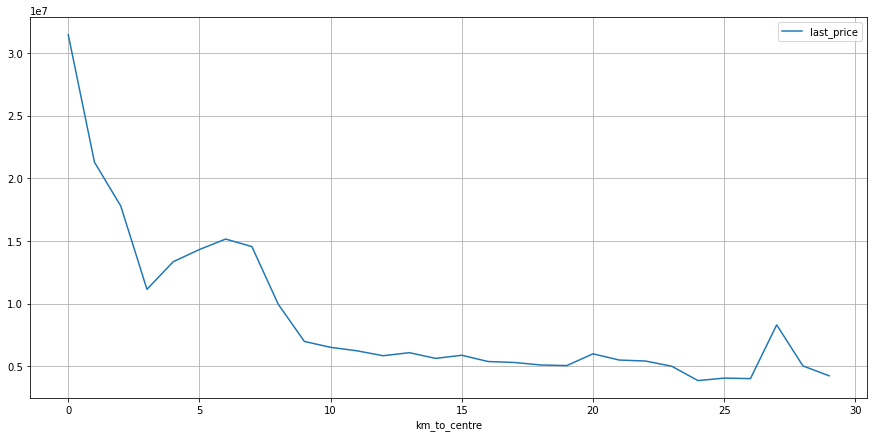

In [66]:
data_sp=data.query('locality_name == "Санкт-Петербург"').reset_index(drop=True) #создадим переменную с объявлениями в Петербурге
data_sp_pivot = data_sp.pivot_table(index='km_to_centre', values='last_price')
print(data_sp_pivot)
print(data_sp_pivot.plot(figsize=(15,7), grid=True))
 #сделаем сводную таблицу зависимости цены до центра города по Петербургу и построим график



In [67]:
data_sp_pivot.describe() #получим средние, минимальные и максимальные значения цены

,last_price
count,3.000000e+01
mean,8.809824e+06
std,6.247718e+06
min,3.854430e+06
25%,5.150516e+06
50%,5.933270e+06
75%,1.084244e+07
max,3.144912e+07


Таким образом мы видим, что чем дальше расположено жилье от центра Петербурга - тем оно дешевле. Минимальная стоимость жилья составляет около 12 млн рублей (самое далекое от центра), а максимальное 33 млн - самое близкое к центру.

### Общий вывод

Мы провели комплексный анализ рынка недвижимости Санкт-Петербурга за 2014-2019 года.

Данные, предоставленные для анализа были с недочетами - мы заменили пропущенные высоты потолков на медианные значения, сбросили пропуски в количестве этажей, так как для анализа это не так важно. Также мы обработали дубликаты в названиях населенных пунктов, округлили значения расстояний, сбросили аномальные значения в графах с высотами потолков. Словом, привели данные в вид, пригодный для дальнейшего анализа.

На основании полученных данных, можно сделать следующие выводы относительно стоимость объектов недвижимости.

Стоимость объектов недвижимости зависит от множества факторов. Во первых, это непосредственные внутренние характеристики объекта - как мы выяснили при исследовании, наиболее сильно на цену влияет общая площать жилья, площадь жилая, площадь кухни. Также влияние оказывает количество комнат в квартире (этот параметр напрямую связан с общей площадью) - чем комнат больше, тем цена выше. 
Как выяснилось - высота потолков, тип жилья не оказывают большого влияния на конечную стоимость. Далее на цену оказывают влияние характеристики расположения жилья относительно самого дома - это этаж. Так, по полученным данным, наименее привлекательные, а следовательно, дешевые варианты - это первые этажи многоквартирных домов. Самой большой стоимостью обладают объекты, расположенные на последних этажах. Но наиболее массовые, находящиеся в среднем ценовом диапазоне, - это объекты со 2 этажа и выше (не включая последний). Также по Петербургу и пригородам заметен тренд на 2-4 этажи, так как сам по себе город не многоэтажный, по сравнению с той же Москвой. Далее на стоимость недвижимости оказывает влияние расстояние до центра города - тут логично сказать, что чем ближе к городскому центру находится жилье, тем оно дороже. Этот вывод подтверждает полученная по Петербургу статистика.
Расстояние до ближайших парков, аэропортов, а также день, месяц, год даты публикации объявления не оказывают значительного влияния на стоимость недвижимости. 

Таким образом получается, что "среднестатистическая квартира" в объявлнеии имеет 2-3 комнаты, находится на 2-4 этаже, находится на расстоянии 5-10 км от центра Петербурга, имеет общую площадь в 50-60 кв метров.

В итоге можно сказать, что, как и ожидалось, на стоимость недвижимости влияют в основном 2 параметра - площадь объекта и его удаленность от центра. Данный принцип работает во всех населенных пунктах.

